## RAG MVP for Operator Training (text + images)

## 0. Environment Setup

In [29]:
import os, io
from PIL import Image
import fitz  # PyMuPDF
import numpy as np
import faiss
from IPython.display import display

from sentence_transformers import SentenceTransformer
from langchain_openai import ChatOpenAI
from langchain.schema import Document


import hashlib
import json, re
from math import inf
from jinja2 import Environment, FileSystemLoader

In [ ]:

# If running locally, uncomment and run these installs:
# !pip install --upgrade pip
# !pip install pymupdf pdfminer.six pillow numpy pandas tqdm faiss-cpu
# !pip install open_clip_torch torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu
# Optional (GPU):
# !pip install open_clip_torch torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# Optional re-ranking or OCR extras:
# !pip install rapidfuzz opencv-python
# If you plan to call OpenAI for step generation:
# !pip install openai


## 1. Configuration

In [ ]:

from dataclasses import dataclass
from pathlib import Path
import os

@dataclass
class Config:
    # Paths
    pdf_dir: str = "data/pdfs"              # Put your manuals here
    out_dir: str = "artifacts"              # Extracted assets & indices
    images_dir_name: str = "images"         # Subfolder for extracted images
    catalog_json: str = "catalog.jsonl"     # Captured page items (texts/images)

    # OpenCLIP model settings
    openclip_model: str = "ViT-B-32"        # e.g., 'ViT-B-32', 'ViT-bigG-14'
    openclip_pretrained: str = "laion2b_s34b_b79k"
    device: str = "cpu"                     # 'cuda' if available

    # Indexing / retrieval
    dims: int = 512                         # OpenCLIP text/image output dims (depends on model)
    top_k: int = 10                         # Top-k results to return
    image_boost: float = 1.0                # Boost factor for image scores

cfg = Config()

# Prepare paths
Path(cfg.pdf_dir).mkdir(parents=True, exist_ok=True)
Path(cfg.out_dir).mkdir(parents=True, exist_ok=True)
Path(os.path.join(cfg.out_dir, cfg.images_dir_name)).mkdir(parents=True, exist_ok=True)

print(cfg)


In [30]:
# --- 1) Settings ---
#PDF_PATH = "data/ManualOp-Modo Manual SIF400_merged_SIF402.pdf"          # Place PDF here
MACHINE_NAME = "SIF402"               # Set the machine name


OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise ValueError("OPENAI_API_KEY not found in env")

PATH_SYSTEM_PROMPT = "config/system_prompt.txt"  # Optional system prompt path
env = Environment(loader=FileSystemLoader("templates"))

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


Could not cache non-existence of file. Will ignore error and continue. Error: [Errno 13] Permission denied: '/home/jovyan/.cache/huggingface/hub/models--sentence-transformers--all-MiniLM-L6-v2/.no_exist/c9745ed1d9f207416be6d2e6f8de32d1f16199bf/adapter_config.json'
Ignored error while writing commit hash to /home/jovyan/.cache/huggingface/hub/models--sentence-transformers--clip-ViT-B-32/refs/main: [Errno 13] Permission denied: '/home/jovyan/.cache/huggingface/hub/models--sentence-transformers--clip-ViT-B-32/refs/main'.


## 2. Utilities

In [ ]:
import json
import re
from typing import List, Dict, Any, Tuple

def norm_space(s: str) -> str:
    return re.sub(r"\s+", " ", s).strip()

def safe_fname(s: str) -> str:
    s = norm_space(s)
    s = re.sub(r"[^a-zA-Z0-9._-]+", "_", s)
    return s[:200]

def heading_score(fontsize: float) -> float:
    # Heuristic: larger font size -> higher heading score
    return fontsize

def build_heading_hierarchy(previous_headings: List[Dict[str, Any]], current: Dict[str, Any]) -> List[Dict[str, Any]]:
    # Simplistic heuristic based on font sizes: if current fontsize is smaller, it could be a subheading
    # Otherwise, it might reset the hierarchy
    if not previous_headings:
        return [current]
    last = previous_headings[-1]
    if current["fontsize"] < last["fontsize"]:
        return previous_headings + [current]  # deeper level
    else:
        return [current]  # reset hierarchy


## 3. PDF Parsing (text blocks, font sizes, images, positions)

In [31]:
# --- 3) Load PDF ---

def load_pdf(PDF_PATH, MACHINE_NAME, text_model, clip_model, min_size=30, ignore_top_pct=0.9, ignore_bottom_pct=0.1):
    """
    Extracts text and images from a PDF with filters.
    
    Args:
        PDF_PATH (str): Path to PDF.
        MACHINE_NAME (str): Machine name prefix (e.g., 'SIF401').
        text_model: SentenceTransformer model for text.
        clip_model: SentenceTransformer model for images.
        min_size (int): Minimum width/height for valid images.

    Returns:
        text_docs, text_embeddings, image_docs, image_embeddings
    """
    doc = fitz.open(PDF_PATH)
    text_docs, text_embeddings = [], []
    image_docs, image_embeddings = [], []
    seen_hashes = set()

    for page_num in range(len(doc)):
        page = doc[page_num]

        # --- Text ---
        text = page.get_text()
        if text.strip():
            emb = text_model.encode(text).astype("float32")
            text_embeddings.append(emb)
            text_docs.append(
                Document(
                    page_content=text,
                    metadata={"page": page_num+1, "machine": MACHINE_NAME}
                )
            )

        # --- Images ---
        img_list = page.get_images(full=True)
        for img_index, img in enumerate(img_list, start=1):
            
            # Example region filter: skip if image is in top 10% or bottom 10% of page        
            x0, y0, x1, y1 = img[0:4]
            page_height = page.rect.height
            if y0 < page_height * ignore_bottom_pct or y1 > page_height * ignore_top_pct:
                continue  # skip logos/icons in header/footer            
            
            xref = img[0]                      
           
            base_img = doc.extract_image(xref)
            img_bytes = base_img["image"]
            img_ext = base_img["ext"]
            img_obj = Image.open(io.BytesIO(img_bytes)).convert("RGB")

            # Filters
            if img_obj.width < min_size or img_obj.height < min_size:
                continue  # skip small logos/icons

            #Skip completely black images
            # img_obj is your PIL.Image object
            img_array = np.array(img_obj)
            # Check if all pixels are 0 (black)
            if img_array.ndim == 3:  # RGB
                if np.all(img_array == 0):
                    continue  # skip completely black image
            elif img_array.ndim == 2:  # grayscale
                if np.all(img_array == 0):
                    continue            
            
            # Check for duplicates using hash
            img_hash = hashlib.md5(img_bytes).hexdigest()
            if img_hash in seen_hashes:
                continue  # skip duplicates
            seen_hashes.add(img_hash)



            # Save image
            out_path = f"data/page{page_num+1}_img{img_index}.{img_ext}"
            img_obj.save(out_path)

            # Embed + save doc
            emb = clip_model.encode(img_obj).astype("float32")
            image_docs.append(
                Document(
                    page_content=f"{MACHINE_NAME}_unknown image on page {page_num+1}, index {img_index}",
                    metadata={
                        "page": page_num+1,
                        "img_path": out_path,
                        "machine": MACHINE_NAME,
                        "object_tag": f"{MACHINE_NAME}_unknown"
                    }
                )
            )
            image_embeddings.append(emb)

    return text_docs, text_embeddings, image_docs, image_embeddings

text_docs, text_embeddings, image_docs, image_embeddings = load_pdf(
    PDF_PATH, MACHINE_NAME, text_model, clip_model
)

In [32]:
# --- 4) Build FAISS indexes ---

text_embeddings = np.vstack(text_embeddings)
image_embeddings = np.vstack(image_embeddings)

text_index = faiss.IndexFlatL2(text_embeddings.shape[1])
text_index.add(text_embeddings)

image_index = faiss.IndexFlatL2(image_embeddings.shape[1])
image_index.add(image_embeddings)

print(f"Indexed {len(text_docs)} text chunks and {len(image_docs)} images.")



Indexed 39 text chunks and 27 images.


In [33]:
# --- 5) Retriever ---
def retrieve(query, k=TOP_K):
    q_text_emb = text_model.encode(query).astype("float32")
    q_img_emb = clip_model.encode(query).astype("float32")

    # Text retrieval
    D, I = text_index.search(np.array([q_text_emb]), k)
    text_results = [text_docs[i] for i in I[0]]

    # Image retrieval
    D, I = image_index.search(np.array([q_img_emb]), k)
    image_results = [image_docs[i] for i in I[0]]

    return text_results, image_results



In [34]:
def rank_images_for_query(query, candidate_images, candidate_embs, img_top_k=2, score_threshold=0.15):
    """Return top-k most relevant images to a query from given candidates.
       Only keep images above a similarity threshold."""
    if not candidate_images:
        return []

    # Encode query with CLIP
    query_emb = clip_model.encode([query]).astype("float32")

    # Build FAISS index for candidate images
    dim = len(query_emb[0])
    index = faiss.IndexFlatIP(dim)
    index.add(np.array(candidate_embs))

    # Search similarity
    D, I = index.search(query_emb, len(candidate_embs))

    # Debug: show scores
    print("\n[DEBUG] Image ranking scores:")
    kept_images = []
    for rank, idx in enumerate(I[0]):
        score = D[0][rank]
        img_meta = candidate_images[idx].metadata
        print(f"  {rank+1}. Page {img_meta['page']} | Tag: {img_meta['object_tag']} | Score: {score:.4f}")

        if score >= score_threshold:
            kept_images.append((candidate_images[idx], score))

    # Return top-k ranked images above threshold
    kept_images = sorted(kept_images, key=lambda x: x[1], reverse=True)
    return [img for img, _ in kept_images[:img_top_k]]

### 6) RAG answer

In [35]:
# --- 6) RAG answer ---
# --- Retrieval & preparation ---

def retrieve_text_and_images(query, k, image_docs, image_embeddings, machine_filter=True):
    """Retrieve text and candidate images for the query."""
    text_results, _ = retrieve(query, k)
    if not text_results:
        return [], [], []

    retrieved_pages = {t.metadata['page'] for t in text_results}
    machine_name = text_results[0].metadata.get('machine', None) if machine_filter else None

    candidate_images = [
        im for im in image_docs
        if im.metadata['page'] in retrieved_pages and
           (machine_name is None or im.metadata.get('machine') == machine_name)
    ]
    candidate_embs = [image_embeddings[image_docs.index(im)] for im in candidate_images]

    return text_results, candidate_images, candidate_embs




In [36]:
def build_image_catalog(filtered_images, image_docs, image_embeddings):
    """Build catalog with IDs, captions, and embeddings."""
    catalog = []
    for i, im in enumerate(filtered_images, start=1):
        img_id = f"IMG_{i}"
        meta = im.metadata
        caption = (
            meta.get('caption') or
            meta.get('description') or
            meta.get('object_tag') or
            f"Image on page {meta.get('page')}"
        )
        catalog.append({
            "id": img_id,
            "page": meta.get('page'),
            "tag": meta.get('object_tag'),
            "caption": caption,
            "path": meta.get('img_path'),
            "emb": image_embeddings[image_docs.index(im)],
            "raw": im
        })
    return catalog




In [37]:
def make_context(text_results, image_catalog):
    """Prepare text + image catalog context for the LLM."""
    text_parts = [
        f"[Text | Page {t.metadata['page']} | {t.metadata.get('machine')}]\\n{t.page_content}"
        for t in text_results
    ]
    catalog_lines = ["IMAGE_CATALOG:"]
    for img in image_catalog:
        catalog_lines.append(
            f"{img['id']} | Page {img['page']} | Tag: {img['tag']} | Caption: {img['caption']} | Path: {img['path']}"
        )
    return "\n\n".join(text_parts + ["\n".join(catalog_lines)])




Prompting & parsing

In [38]:
# --- Prompting & parsing --------------------------------------------------

def load_system_prompt(path) -> str:
    """Load system prompt text from a file."""
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            return f.read().strip()
    return ""

def make_prompt(query, context, min_images_per_step=1, system_prompt_file=PATH_SYSTEM_PROMPT):
    """Render operator assistant prompt using Jinja2 template and system prompt file."""
    template = env.get_template("operator_prompt.j2")
    system_prompt = load_system_prompt(system_prompt_file)
    return template.render(
        query=query,
        context=context,
        min_images_per_step=min_images_per_step,
        system_prompt=system_prompt,
    )


def parse_llm_output(raw_answer):
    """Parse JSON output from LLM, fallback to heuristic if needed."""
    try:
        return json.loads(raw_answer)
    except Exception:
        m = re.search(r"(\{.*\})", raw_answer, flags=re.S)
        if m:
            try:
                return json.loads(m.group(1))
            except Exception:
                pass

    # fallback: heuristic step split
    steps, current = [], {"title": "", "instruction": "", "image_ids": []}
    for line in raw_answer.splitlines():
        L = line.strip()
        if re.match(r"^(Step|STEP|step)\b", L) or re.match(r"^\d+\.", L):
            if current["instruction"]:
                steps.append(current)
                current = {"title": "", "instruction": "", "image_ids": []}
            current["title"] = L
        else:
            current["instruction"] += (" " + L) if current["instruction"] else L
    if current["instruction"]:
        steps.append(current)
    return {"steps": steps, "sources": []}




Post-processing

In [39]:
# --- Post-processing ---

def auto_attach_images(steps, image_catalog, text_encoder, min_images_per_step=1, sim_thresh=0.1):
    """Ensure each step has at least one relevant image via embeddings."""
    if not callable(text_encoder):
        return steps

    import numpy as np
    for step in steps:
        if len(step.get("image_ids", [])) >= min_images_per_step:
            continue

        instr = step.get("instruction", "")
        try:
            instr_emb = text_encoder(instr)
        except Exception:
            continue

        best, best_img, best_score = None, None, -inf
        for img in image_catalog:
            try:
                a, b = np.asarray(instr_emb), np.asarray(img["emb"])
                denom = (np.linalg.norm(a) * np.linalg.norm(b))
                sim = np.dot(a, b) / denom if denom else -1.0
            except Exception:
                sim = -1.0
            if sim > best_score:
                best, best_img, best_score = img["id"], img, sim

        if best and best_score >= sim_thresh:
            step.setdefault("image_ids", []).append(best)

    return steps




In [40]:
# --- Display ---

def display_steps(steps, image_catalog):
    """Print structured steps and show images."""
    for i, step in enumerate(steps, start=1):
        title = step.get("title", f"Step {i}")
        print(f"--- {title} ---")
        print(step.get("instruction", ""))
        ids = step.get("image_ids", [])
        if ids:
            print("Images:", ids)
            for img_id in ids:
                entry = next((im for im in image_catalog if im["id"] == img_id), None)
                if entry:
                    print(f"- {img_id} | Page {entry['page']} | Tag: {entry['tag']} | {entry['path']}")
                    try:
                        display(Image.open(entry["path"]))
                    except Exception as e:
                        print(f"  (Error opening {entry['path']} — {e})")
        print()


Main wrapper

In [41]:
# --- Main wrapper -------------------------------------------------------------

def ask(query, k=TOP_K, img_top_k=2, score_threshold=0.15, min_images_per_step=1):
    """Main RAG pipeline with image-aware steps."""
    # 1) Retrieve
    text_results, candidate_images, candidate_embs = retrieve_text_and_images(
        query, k, image_docs, image_embeddings
    )
    if not text_results:
        print("No relevant text found.")
        return

    # 2) Rank images
    filtered_images = rank_images_for_query(
        query, candidate_images, candidate_embs,
        img_top_k=img_top_k, score_threshold=score_threshold
    )
    image_catalog = build_image_catalog(filtered_images, image_docs, image_embeddings)

    # 3) Prompt LLM
    context = make_context(text_results, image_catalog)
    prompt = make_prompt(query, context, min_images_per_step)
    raw_answer = llm.invoke(prompt).content.strip()

    # 4) Parse & fallback attach
    parsed = parse_llm_output(raw_answer)
    steps = parsed.get("steps", [])
    steps = auto_attach_images(
        steps, image_catalog,
        globals().get("encode_text") or globals().get("encode_query"),
        min_images_per_step
    )

    # 5) Display
    print("\n=== Structured Answer ===\n")
    display_steps(steps, image_catalog)
    if parsed.get("sources"):
        print("Sources:", parsed["sources"])



[DEBUG] Image ranking scores:
  1. Page 33 | Tag: SIF402_unknown | Score: 25.6650
  2. Page 33 | Tag: SIF402_unknown | Score: 24.3419
  3. Page 38 | Tag: SIF402_unknown | Score: 23.6422
  4. Page 33 | Tag: SIF402_unknown | Score: 22.6173

=== Structured Answer ===

--- Step 1: Refill the Red Pellets ---
Locate the hopper designated for red pellets and refill it with the appropriate red pellets. Ensure that the hopper is properly filled to the required level.
Images: ['IMG_1']
- IMG_1 | Page 33 | Tag: SIF402_unknown | data/page33_img3.png


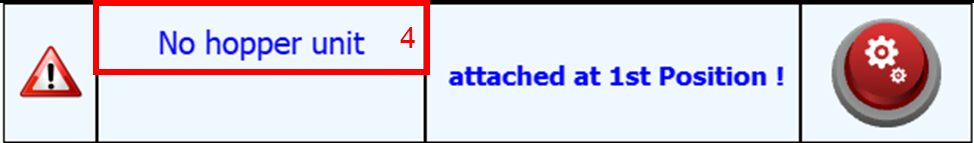


--- Step 2: Verify Hopper Detection ---
After refilling, check the 'Station Configuration' screen on the HMI panel to ensure that the hopper is detected. If it is not detected, adjust the hopper's position until it is recognized.
Images: ['IMG_2']
- IMG_2 | Page 33 | Tag: SIF402_unknown | data/page33_img2.jpeg


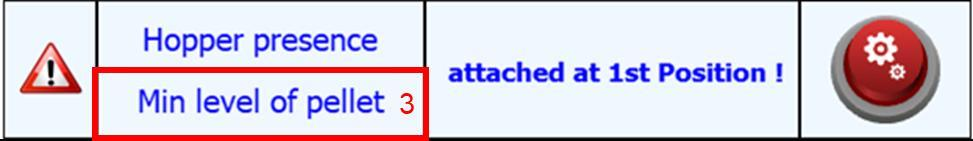


--- Step 3: Reset the System ---
Once the hopper is detected, press the RESET button on the main screen of the HMI panel to clear the message and resume production.

Sources: ['Page 37', 'Page 33']


In [42]:
# --- 7) Example usage ---
if __name__ == "__main__":
    #ask(f"How to switch on and start up the station {MACHINE_NAME} ?")
    ask(f"I see in the panel in {MACHINE_NAME} a message: 'Please refill red pellets', what should I do?")